In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama

from src.agent.ShellTool import ShellTool

In [2]:
# define general state structure
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [3]:
# define chatbot node
llm = ChatOllama(model="llama3.1:8b")
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name,
# the second argument is the actual function that will be called
graph_builder.add_node("chatbot", chatbot)

In [4]:
# define start state and end edge
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)  #"any time this node is run, you can exit."


In [5]:
# compile the graph to make it ready to be executed
graph = graph_builder.compile()

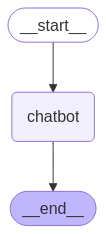

In [6]:
# visualization
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
# run the chatbot

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]: break
    stream_graph_updates(user_input)
